In [15]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [16]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

# To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
backend = AerSimulator()
backend

AerSimulator('aer_simulator')

In [72]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("IZ", -0.3980), ("ZI", -0.0113), ("XX", 0.1810)]
)
# hamiltonian = SparsePauliOp.from_list(
#     [("YZ", 1), ("ZI", 1), ("ZZ", 1), ("XX", 1)]
# )

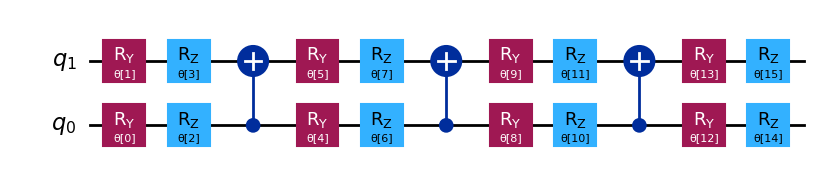

In [73]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [74]:
num_params = ansatz.num_parameters
num_params

16

In [75]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

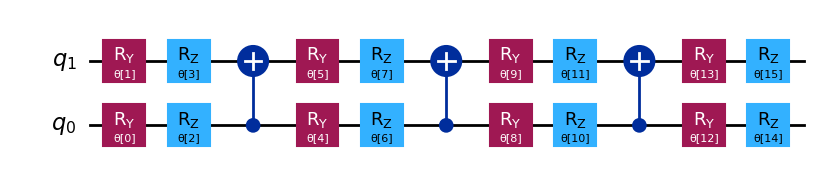

In [76]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [77]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

#### Cost Function

In [78]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    print(result[0].data.evs)
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [79]:
np.random.seed(42)
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([2.35330497, 5.97351416, 4.59925358, 3.76148219, 0.98029403,
       0.98014248, 0.3649501 , 5.44234523, 3.77691701, 4.44895122,
       0.12933619, 6.09412333, 5.23039137, 1.33416598, 1.14243996,
       1.15236452])

In [80]:
estimator = Estimator(backend=AerSimulator())
estimator.options.seed_estimator = 10
print(estimator.options.seed_estimator)

10


In [81]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 1000
    estimator.options.seed_estimator = 10

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

[0.32004336]
Iters. done: 1 [Current cost: 0.320043359375]
[-0.01220293]
Iters. done: 2 [Current cost: -0.012202929687500003]


[-0.24903042]
Iters. done: 3 [Current cost: -0.24903041992187502]
[-0.15847241]
Iters. done: 4 [Current cost: -0.15847241210937502]
[0.06900288]
Iters. done: 5 [Current cost: 0.069002880859375]
[-0.0233645]
Iters. done: 6 [Current cost: -0.023364501953125]
[-0.47291519]
Iters. done: 7 [Current cost: -0.47291518554687506]
[-0.50481562]
Iters. done: 8 [Current cost: -0.504815625]
[-0.52131099]
Iters. done: 9 [Current cost: -0.521310986328125]
[-0.38256816]
Iters. done: 10 [Current cost: -0.38256816406249994]
[-0.47918403]
Iters. done: 11 [Current cost: -0.4791840332031251]
[-0.49591997]
Iters. done: 12 [Current cost: -0.495919970703125]
[-0.34873472]
Iters. done: 13 [Current cost: -0.348734716796875]
[-0.38984844]
Iters. done: 14 [Current cost: -0.3898484375]
[-0.56650747]
Iters. done: 15 [Current cost: -0.566507470703125]
[-0.62276748]
Iters. done: 16 [Current cost: -0.62276748046875]
[-0.23584453]
Iters. done: 17 [Current cost: -0.23584453125]
[-0.55574468]
Iters. done: 18 [Current cos

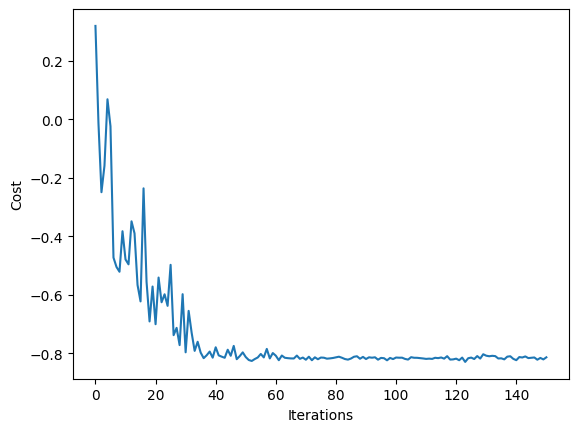

In [82]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [83]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 1000
    estimator.options.seed_estimator = 10

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

[0.29580347]
Iters. done: 152 [Current cost: 0.295803466796875]
[-0.03006978]
Iters. done: 153 [Current cost: -0.030069775390624998]
[-0.24879487]
Iters. done: 154 [Current cost: -0.248794873046875]
[-0.18993984]
Iters. done: 155 [Current cost: -0.18993984375]
[0.08841162]
Iters. done: 156 [Current cost: 0.08841162109375002]
[0.00790537]
Iters. done: 157 [Current cost: 0.007905371093750002]
[-0.50071621]
Iters. done: 158 [Current cost: -0.5007162109375]
[-0.49557563]
Iters. done: 159 [Current cost: -0.49557563476562505]
[-0.64674517]
Iters. done: 160 [Current cost: -0.646745166015625]
[-0.54584492]
Iters. done: 161 [Current cost: -0.545844921875]
[-0.75433955]
Iters. done: 162 [Current cost: -0.75433955078125]
[-0.53322788]
Iters. done: 163 [Current cost: -0.5332278808593751]
[-0.5972312]
Iters. done: 164 [Current cost: -0.597231201171875]
[-0.59093369]
Iters. done: 165 [Current cost: -0.5909336914062501]
[-0.64402769]
Iters. done: 166 [Current cost: -0.644027685546875]
[-0.75918906]
I

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

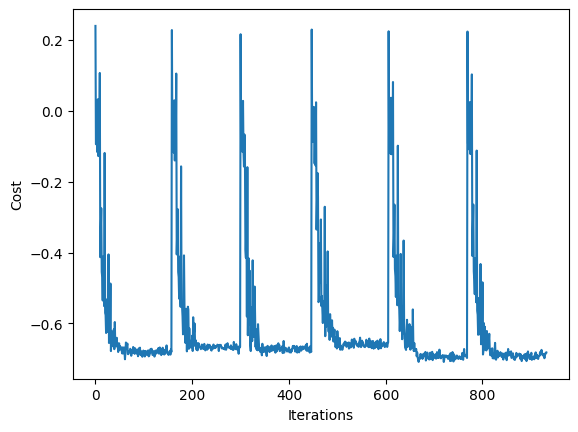

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()